### Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
print(tf.version.VERSION)

2.10.0


### Untarring and Saving to Local Directory

In [15]:
fullPath = os.path.abspath("./" + "lfw.tgz")
data_lfw = keras.utils.get_file("lfw.tgz", 'file://'+ fullPath, untar=True, cache_dir=".")
dataset_dir = os.path.join(os.path.dirname(data_lfw), "lfw")

### Creating Dataset from Images

In [16]:
data_dir_1 = "./datasets/face_lfw"
# data_dir_2 = "./datasets/nonface"
image_size = 256
batch_size = 128
color_bytes = 3

# train_data, test_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=20, image_size=image_size, batch_size=batch_size)


In [17]:
# Getting number of files in directory

count = 0
for root_dir, cur_dir, files in os.walk(data_dir_1):
    count += len(files)
print('file count:', count)


file count: 19150


In [18]:
# Creating Dataset from Face Images

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

Found 19146 files belonging to 2 classes.
Using 15317 files for training.
Found 19146 files belonging to 2 classes.
Using 3829 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['faces', 'nonfaces']


### Displaying Sample Data

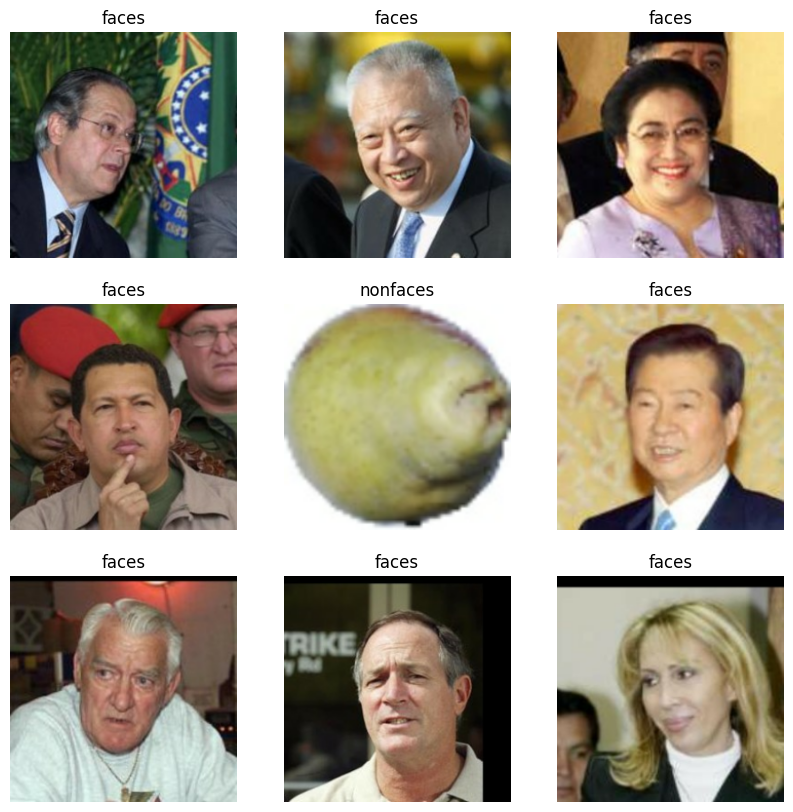

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [25]:
#result = self.step(batch, self.forward_only)

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Save the entire model as a SavedModel.
model.save('saved_model/lfw_model_base')

Epoch 1/10


2022-12-01 14:42:15.469329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 54 of 1000
2022-12-01 14:42:25.402290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 117 of 1000
2022-12-01 14:42:25.541055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


120/120 [==============================] - 326s 3s/step - loss: 0.2154 - accuracy: 0.9025 - val_loss: 0.0310 - val_accuracy: 0.9882
Epoch 2/10
120/120 [==============================] - 317s 3s/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0259 - val_accuracy: 0.9919
Epoch 3/10
120/120 [==============================] - 313s 3s/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0122 - val_accuracy: 0.9958
Epoch 4/10
120/120 [==============================] - 301s 3s/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.0097 - val_accuracy: 0.9963
Epoch 5/10
120/120 [==============================] - 309s 3s/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0076 - val_accuracy: 0.9976
Epoch 6/10
120/120 [==============================] - 298s 2s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0072 - val_accuracy: 0.9966
Epoch 7/10
120/120 [==============================] - 300s 2s/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0101 - val_accuracy: 0.9969
Epoch 8/10

INFO:tensorflow:Assets written to: saved_model/lfw_model_base/assets


INFO:tensorflow:Assets written to: saved_model/lfw_model_base/assets


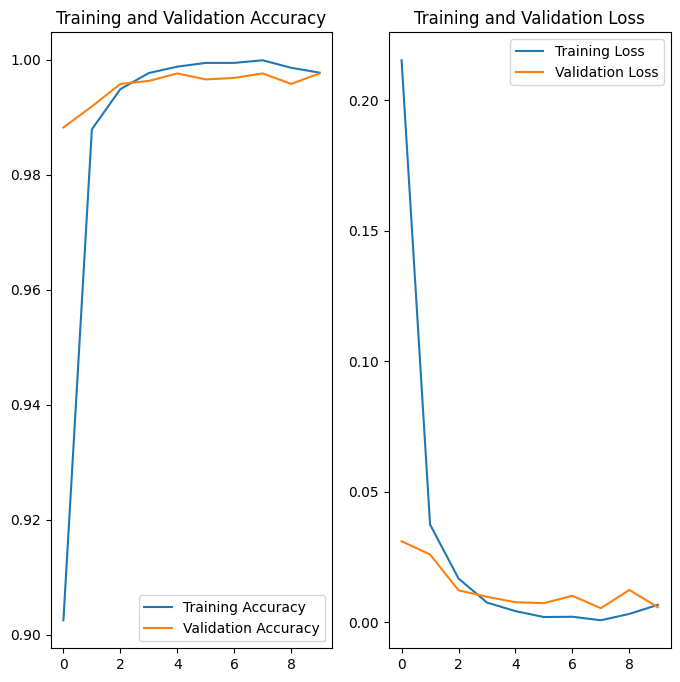

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

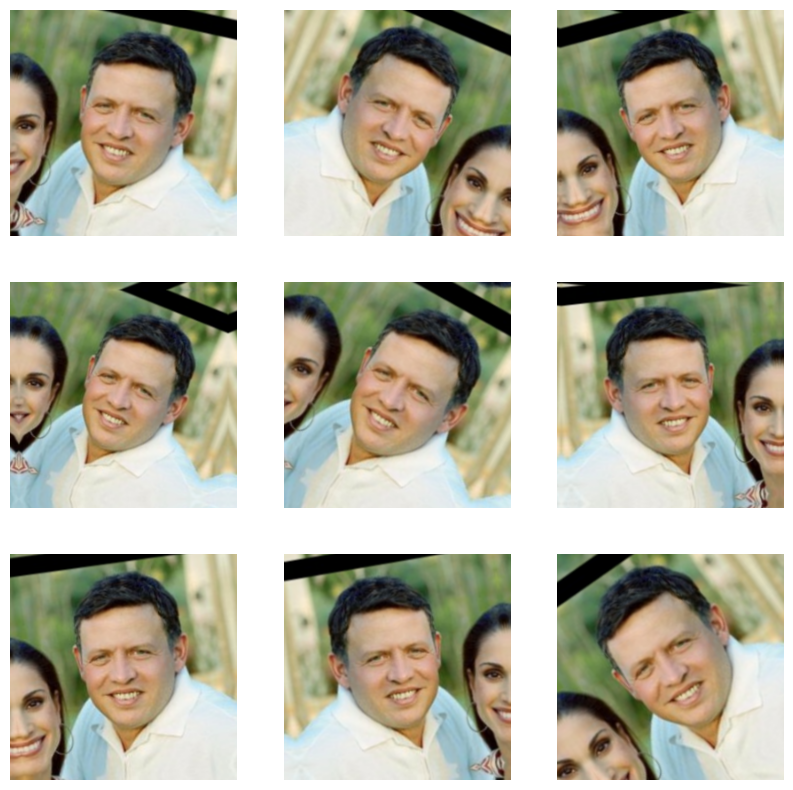

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [32]:
epochs = 10
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# Save the entire model as a SavedModel.
model_2.save('saved_model/lfw_model_additional')

Epoch 1/10


120/120 [==============================] - 379s 3s/step - loss: 0.3642 - accuracy: 0.8494 - val_loss: 0.1087 - val_accuracy: 0.9566
Epoch 2/10
120/120 [==============================] - 376s 3s/step - loss: 0.0701 - accuracy: 0.9756 - val_loss: 0.0423 - val_accuracy: 0.9854
Epoch 3/10
120/120 [==============================] - 382s 3s/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.0244 - val_accuracy: 0.9911
Epoch 4/10
120/120 [==============================] - 376s 3s/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0118 - val_accuracy: 0.9969
Epoch 5/10
120/120 [==============================] - 387s 3s/step - loss: 0.0288 - accuracy: 0.9895 - val_loss: 0.0158 - val_accuracy: 0.9927
Epoch 6/10
120/120 [==============================] - 388s 3s/step - loss: 0.0225 - accuracy: 0.9926 - val_loss: 0.0100 - val_accuracy: 0.9963
Epoch 7/10
120/120 [==============================] - 387s 3s/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0062 - val_accuracy: 0.9976
Epoch 8/10

INFO:tensorflow:Assets written to: saved_model/lfw_model_additional/assets


INFO:tensorflow:Assets written to: saved_model/lfw_model_additional/assets


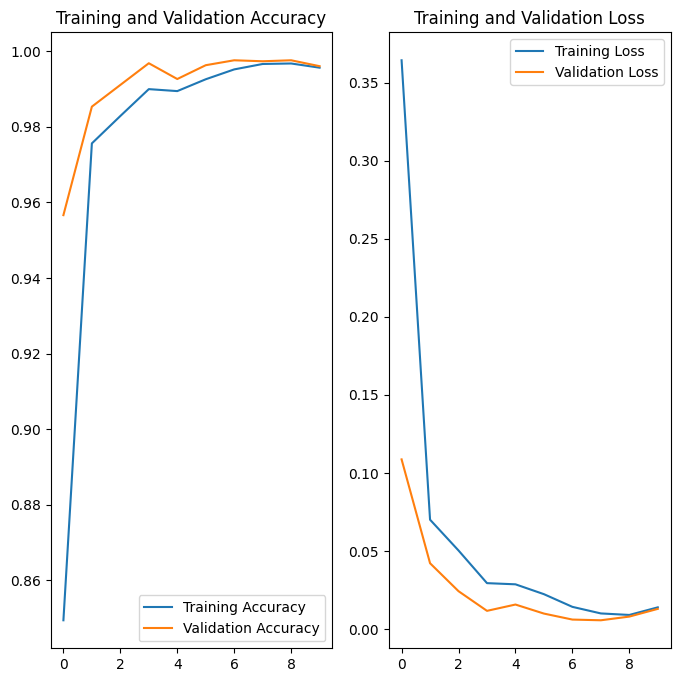

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
img_url = "https://img.freepik.com/free-photo/portrait-white-man-isolated_53876-40306.jpg"
img_path = tf.keras.utils.get_file('test_img_3', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_size, image_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

img_url = "https://images.unsplash.com/photo-1484591974057-265bb767ef71?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MXx8fGVufDB8fHx8&w=1000&q=80"
img_path = tf.keras.utils.get_file('test_img_4', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_size, image_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 331ms/step
[[ 5.756322  -0.5124233]]
This image most likely belongs to faces with a 99.81 percent confidence.
1/1 [==============================] - 0s 55ms/step
[[-2.3028762  6.634493 ]]
This image most likely belongs to nonfaces with a 99.99 percent confidence.
